In [1]:
import os
import sys
import pdb
import re
import json
import copy
import pickle
import glob
import tqdm
import importlib
import functools
import numpy as np
import pandas as pd
import soundfile as sf
import soxr
import scipy.signal
import tqdm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import util

sys.path.append('/om2/user/msaddler/tfauditoryutil')
import util_spkr_word_psychophysics_figures
import util_signal

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

tqdm.tqdm.pandas()


2024-01-28 17:12:44.127280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 17:12:47.969451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open('data/model_data_spkr_word.pkl', 'rb') as f:
    EXPERIMENT_DATAFRAMES = pickle.load(f)
for k in EXPERIMENT_DATAFRAMES.keys():
    print(k)
df = EXPERIMENT_DATAFRAMES['kell_like']
for k in df.tag_model.unique():
    print(f'"human": "{k}",')

map_k_to_tag_model = {
    "human": "human",
    "50": "saved_models/augmented_2022JAN/taskSW/IHC0050Hz_anf384H160M096L/arch0_00??",
    "320": "saved_models/augmented_2022JAN/taskSW/IHC0320Hz_anf384H160M096L/arch0_00??",
    "1000": "saved_models/augmented_2022JAN/taskSW/IHC1000Hz_anf384H160M096L/arch0_00??",
    "3000": "saved_models/augmented_2022JAN/taskSW/IHC3000Hz_anf384H160M096L/arch0_00??",
    "50_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0050/arch0_00??",
    "320_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0320/arch0_00??",
    "1000_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC1000/arch0_00??",
    "3000_simple": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC3000/arch0_00??",
    "50_spkr": "saved_models/augmented_2022JAN/task_S/IHC0050Hz_anf384H160M096L/arch0_00??",
    "320_spkr": "saved_models/augmented_2022JAN/task_S/IHC0320Hz_anf384H160M096L/arch0_00??",
    "1000_spkr": "saved_models/augmented_2022JAN/task_S/IHC1000Hz_anf384H160M096L/arch0_00??",
    "3000_spkr": "saved_models/augmented_2022JAN/task_S/IHC3000Hz_anf384H160M096L/arch0_00??",
    "50_word": "saved_models/augmented_2022JAN/task_W/IHC0050Hz_anf384H160M096L/arch0_00??",
    "320_word": "saved_models/augmented_2022JAN/task_W/IHC0320Hz_anf384H160M096L/arch0_00??",
    "1000_word": "saved_models/augmented_2022JAN/task_W/IHC1000Hz_anf384H160M096L/arch0_00??",
    "3000_word": "saved_models/augmented_2022JAN/task_W/IHC3000Hz_anf384H160M096L/arch0_00??",
}


kell_like_inharmonic
kell_like
speech_in_synthetic_textures
pitch_altered
hopkins_moore_2009_raw
hopkins_moore_2009
spkr_discrimination_timit_ssn
"human": "human",
"human": "saved_models/augmented_2022JAN/taskSW/IHC0050Hz_anf384H160M096L/arch0_00??",
"human": "saved_models/augmented_2022JAN/taskSW/IHC0320Hz_anf384H160M096L/arch0_00??",
"human": "saved_models/augmented_2022JAN/taskSW/IHC1000Hz_anf384H160M096L/arch0_00??",
"human": "saved_models/augmented_2022JAN/taskSW/IHC3000Hz_anf384H160M096L/arch0_00??",
"human": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0050/arch0_00??",
"human": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC0320/arch0_00??",
"human": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC1000/arch0_00??",
"human": "saved_models/augmented_2022JAN/taskSW/spont0_simplified_IHC3000/arch0_00??",
"human": "saved_models/augmented_2022JAN/task_S/IHC0050Hz_anf384H160M096L/arch0_00??",
"human": "saved_models/augmented_2022JAN/task_S/IHC03

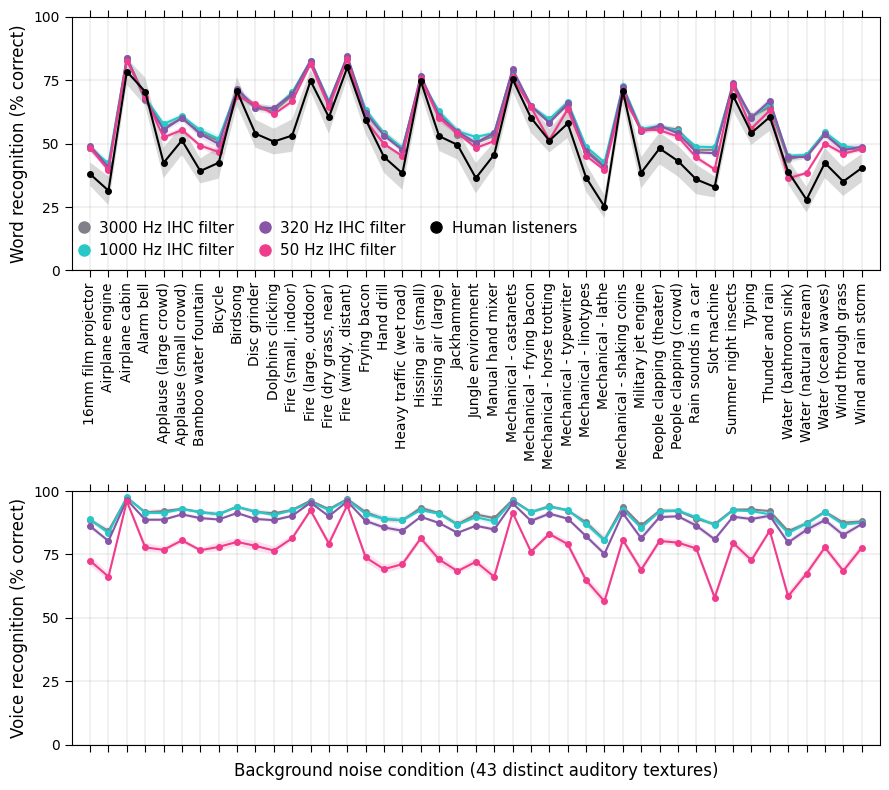

figures_src/results_spkr_word_speech_in_synthetic_textures.pdf


In [9]:
importlib.reload(util_spkr_word_psychophysics_figures)

df_results = EXPERIMENT_DATAFRAMES['speech_in_synthetic_textures']
list_k_model = [
    '3000',
    '1000',
    '320',
    '50',
    'human',
]

map_int_to_label = {
    0: '16mm film projector',
    1: 'Airplane engine',
    2: 'Airplane cabin',
    3: 'Alarm bell',
    4: 'Applause (large crowd)',
    5: 'Applause (small crowd)',
    6: 'Bamboo water fountain',
    7: 'Bicycle',
    8: 'Birdsong',
    9: 'Disc grinder',
    10: 'Dolphins clicking',
    11: 'Fire (small, indoor)',
    12: 'Fire (large, outdoor)',
    13: 'Fire (dry grass, near)',
    14: 'Fire (windy, distant)',
    15: 'Frying bacon',
    16: 'Hand drill',
    17: 'Heavy traffic (wet road)',
    18: 'Hissing air (small)',
    19: 'Hissing air (large)',
    20: 'Jackhammer',
    21: 'Jungle environment',
    22: 'Manual hand mixer',
    23: 'Mechanical - castanets',
    24: 'Mechanical - frying bacon',
    25: 'Mechanical - horse trotting',
    26: 'Mechanical - typewriter',
    27: 'Mechanical - linotypes',
    28: 'Mechanical - lathe',
    29: 'Mechanical - shaking coins',
    30: 'Military jet engine',
    31: 'People clapping (theater)',
    32: 'People clapping (crowd)',
    33: 'Rain sounds in a car',
    34: 'Slot machine',
    35: 'Summer night insects',
    36: 'Typing',
    37: 'Thunder and rain',
    38: 'Water (bathroom sink)',
    39: 'Water (natural stream)',
    40: 'Water (ocean waves)',
    41: 'Wind through grass',
    42: 'Wind and rain storm',
}
xticks = np.arange(len(map_int_to_label)).astype(int)
xticklabels = [map_int_to_label[_] for _ in xticks]

list_key_task = [
    'word',
    'spkr',
]

fig, ax_arr = plt.subplots(nrows=len(list_key_task), ncols=1, figsize=(9, 8))
for itr_ax, key_task in enumerate(list_key_task):
    ax = ax_arr[itr_ax]
    for itr_model, k in enumerate(list_k_model):
        tag_model = map_k_to_tag_model[k]
        color, label = util.get_color_and_label_from_model_tag(tag_model)
        df = df_results[df_results.tag_model == tag_model]
        kwargs_plot_update = {
            'label': label,
        }
        kwargs_legend_update = {
            'fontsize': 11,
            'handlelength': 0,
            'markerscale': 2,
            'ncols': 3,
            'borderaxespad': 0.5,
            'loc': 'lower left',
        }
        kwargs_format_axes_update = {
            'fontsize_ticks': 10,
            'xticks': xticks,
            'xticklabels': xticklabels if itr_ax == 0 else [],
            'str_xlabel': 'Background noise condition (43 distinct auditory textures)' if itr_ax == 1 else None,
            'major_tick_params_kwargs_update': {'top': True},
        }
        if len(df) > 0:
            ax = util_spkr_word_psychophysics_figures.make_plot_speech_in_synthetic_textures(
                ax,
                df,
                key_task=key_task,
                color=color,
                kwargs_plot_update=kwargs_plot_update,
                kwargs_legend_update=kwargs_legend_update,
                kwargs_format_axes_update=kwargs_format_axes_update,
                include_legend=key_task=='word')
    if itr_ax == 0:
        ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
    ax.grid(lw=0.25)
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/results_spkr_word_speech_in_synthetic_textures.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


In [10]:
df_results[df_results.tag_model == 'human'].correct_word_mean.min(), df_results[df_results.tag_model == 'human'].correct_word_mean.max()

(0.25201388888888887, 0.8011607142857142)

In [11]:
list_k = [
    '3000',
    '1000',
    '320',
    '50',
    'human',
]
dict_split_half = {}
for k in list_k:
    df_to_split = df_results[np.logical_and.reduce([
        df_results.tag_model == map_k_to_tag_model[k],
        df_results.snr == -3,
    ])].copy()
    df_to_split['fn_eval'] = df_to_split['correct_word_list'].map(lambda _: list(range(len(_))))
    df_to_split = df_to_split.explode(column=['correct_word_list', 'correct_spkr_list', 'fn_eval'])
    list_fn_eval = df_to_split.fn_eval.unique()
    n = len(list_fn_eval)
    print(f'Computing split-half reliability for {n} participants ({k})')
    dict_split_half[k] = {'spkr': [], 'word': []}
    np.random.seed(0)
    for _ in tqdm.tqdm(range(100)):
        np.random.shuffle(list_fn_eval)
        df0 = df_to_split[df_to_split['fn_eval'].isin(list_fn_eval[:int(n / 2)])]
        df1 = df_to_split[df_to_split['fn_eval'].isin(list_fn_eval[int(n / 2):])]
        df0 = df0.groupby(['tag_model', 'index_texture', 'snr']).agg({
            'correct_word_list': 'mean',
            'correct_spkr_list': 'mean',
        }).reset_index()
        df1 = df1.groupby(['tag_model', 'index_texture', 'snr']).agg({
            'correct_word_list': 'mean',
            'correct_spkr_list': 'mean',
        }).reset_index()
        index0 = df0.index_texture.values
        index1 = df1.index_texture.values
        assert np.array_equal(index0, index1)
        for key_task in dict_split_half[k].keys():
            x0 = 100 * df0[f'correct_{key_task}_list'].values
            x1 = 100 * df1[f'correct_{key_task}_list'].values
            if not np.isnan(x0).any():
                r, p = scipy.stats.pearsonr(x0, x1)
                r = (2 * r) / (1 + r)
                dict_split_half[k][key_task].append(r)
    dict_split_half[k] = {key_task: np.mean(v) for key_task, v in dict_split_half[k].items()}
dict_split_half


Computing split-half reliability for 10 participants (3000)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.91it/s]


Computing split-half reliability for 10 participants (1000)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.06it/s]


Computing split-half reliability for 10 participants (320)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.27it/s]


Computing split-half reliability for 10 participants (50)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.11it/s]


Computing split-half reliability for 43 participants (human)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.66it/s]
/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/msaddler/.conda/envs/tf/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'3000': {'spkr': 0.991812411386391, 'word': 0.997964686129796},
 '1000': {'spkr': 0.9926381646197475, 'word': 0.9983948185396625},
 '320': {'spkr': 0.9933948352467681, 'word': 0.9985832211231476},
 '50': {'spkr': 0.9974737480557577, 'word': 0.9985050222500764},
 'human': {'spkr': nan, 'word': 0.9677674727498684}}

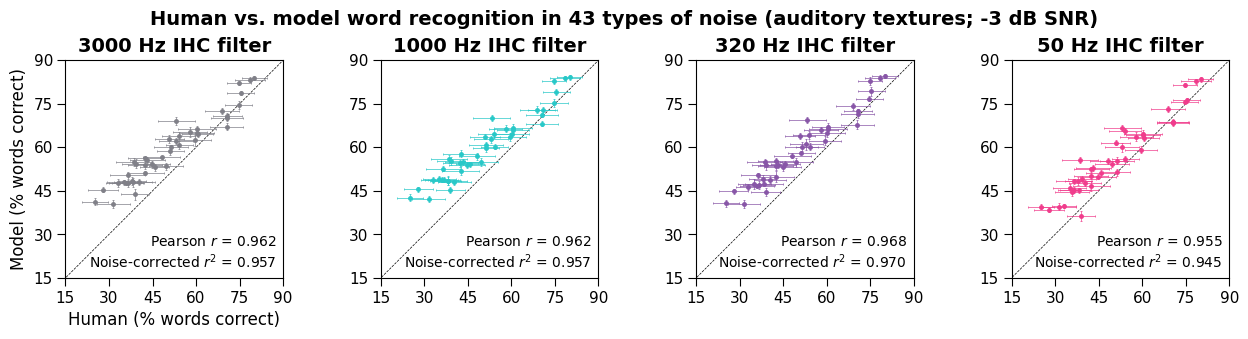

figures_src/results_spkr_word_speech_in_synthetic_textures_human_vs_model.pdf


In [14]:
list_key_txy = [
    ('word', 'word', 'human', '3000'),
    ('word', 'word', 'human', '1000'),
    ('word', 'word', 'human', '320'),
    ('word', 'word', 'human', '50'),
]
fig, ax_arr = plt.subplots(figsize=(3.25 * len(list_key_txy), 3.25), ncols=len(list_key_txy), nrows=1)
ax_arr = np.array(ax_arr).reshape([len(list_key_txy)])

for itr_ax, (key_task_x, key_task_y, key_x, key_y) in enumerate(list_key_txy):
    ax = ax_arr[itr_ax]
    tag_x = map_k_to_tag_model[key_x]
    tag_y = map_k_to_tag_model[key_y]
    dfx = df_results[np.logical_and.reduce([
        df_results.tag_model == tag_x,
        df_results.snr == -3,
    ])]
    dfy = df_results[np.logical_and.reduce([
        df_results.tag_model == tag_y,
        df_results.snr == -3,
    ])]
    index_x = dfx.index_texture.values
    index_y = dfy.index_texture.values
    assert np.array_equal(index_x, index_y)
    x = 100 * dfx[f'correct_{key_task_x}_mean'].values
    xerr = 2 * 100 * dfx[f'correct_{key_task_x}_sem'].values
    y = 100 * dfy[f'correct_{key_task_y}_mean'].values
    yerr = 2 * 100 * dfy[f'correct_{key_task_y}_sem'].values    
    color_x, label_x = util.get_color_and_label_from_model_tag(tag_x)
    color_y, label_y = util.get_color_and_label_from_model_tag(tag_y)
    
    r, p = scipy.stats.pearsonr(x, y)
    rmse = np.sqrt(np.mean(np.square(x - y)))

    split_half_r2x = dict_split_half[key_x][key_task_x] ** 2
    split_half_r2y = dict_split_half[key_y][key_task_y] ** 2
    ncr2 = ((r ** 2) / np.exp(np.mean(np.log([split_half_r2x, split_half_r2y]))))
    
    label = 'Pearson $r$ = {:.3f}\nNoise-corrected $r^2$ = {:.3f}'.format(r, ncr2)
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker='', ls='', color=color_y, lw=0.5, mew=0.5, capsize=1, capthick=0.5)
    ax.plot(x, y, marker='o', ms=2.5, ls='', color=color_y, label=label)
    kwargs_legend = {
        'loc': 'lower right',
        'frameon': False,
        'markerscale': 0,
        'handlelength': 0,
        'borderaxespad': 0,
        'handletextpad': 0,
        'borderpad': 0.5,
        'fontsize': 10,
    }
    legend = ax.legend(**kwargs_legend)
    for t in legend.get_texts():
        t.set_ha('right')
    ax.plot([0, 100], [0, 100], color='k', ls='--', lw=0.5, zorder=-100)
    ax = util_figures.format_axes(
        ax,
        str_title=f'{label_y}',
        str_xlabel='Human (% {}s correct)'.format('word' if key_task_x == 'word' else 'voice') if itr_ax == 0 else None,
        str_ylabel='Model (% {}s correct)'.format('word' if key_task_y == 'word' else 'voice') if itr_ax == 0 else None,
        xlimits=[15, 90],
        ylimits=[15, 90],
        xticks=np.arange(15, 91, 15),
        yticks=np.arange(15, 91, 15),
        fontweight_title='bold',
        fontsize_ticks=11,
        fontsize_labels=12,
        fontsize_title=14,
    )
    ax.set_aspect('equal')
fig.tight_layout()
fig.subplots_adjust(top=0.825)
fig.suptitle("Human vs. model word recognition in 43 types of noise (auditory textures; -3 dB SNR)", fontweight='bold', fontsize=14)
plt.show()

fn_fig = 'figures_src/results_spkr_word_speech_in_synthetic_textures_human_vs_model.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


key_task_x='word' | min=-1.6223404255319025, max=7.7127659574468055, mean=2.250123701138052, median=1.8617021276595693, s.d.=2.341522697368129
key_task_x='spkr' | min=1.3563829787234027, max=28.936170212765965, mean=14.905987135081638, median=14.122340425531902, s.d.=5.730326610950737


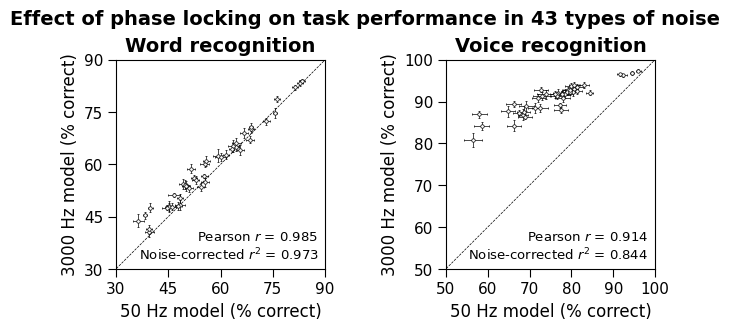

figures_src/results_spkr_word_speech_in_synthetic_textures_model_vs_model.pdf


In [16]:
list_key_txy = [
    ('word', 'word', '50', '3000'),
    ('spkr', 'spkr', '50', '3000'),
]
fig, ax_arr = plt.subplots(figsize=(3.35 * len(list_key_txy), 3.25), ncols=len(list_key_txy), nrows=1)
ax_arr = np.array(ax_arr).reshape([len(list_key_txy)])

for itr_ax, (key_task_x, key_task_y, key_x, key_y) in enumerate(list_key_txy):
    ax = ax_arr[itr_ax]
    tag_x = map_k_to_tag_model[key_x]
    tag_y = map_k_to_tag_model[key_y]
    dfx = df_results[np.logical_and.reduce([
        df_results.tag_model == tag_x,
        df_results.snr == -3,
    ])]
    dfy = df_results[np.logical_and.reduce([
        df_results.tag_model == tag_y,
        df_results.snr == -3,
    ])]
    index_x = dfx.index_texture.values
    index_y = dfy.index_texture.values
    assert np.array_equal(index_x, index_y)
    x = 100 * dfx[f'correct_{key_task_x}_mean'].values
    xerr = 2 * 100 * dfx[f'correct_{key_task_x}_sem'].values
    y = 100 * dfy[f'correct_{key_task_y}_mean'].values
    yerr = 2 * 100 * dfy[f'correct_{key_task_y}_sem'].values    
    color_x, label_x = util.get_color_and_label_from_model_tag(tag_x)
    color_y, label_y = util.get_color_and_label_from_model_tag(tag_y)
    color_y = 'k'
    
    r, p = scipy.stats.pearsonr(x, y)
    rmse = np.sqrt(np.mean(np.square(x - y)))
    split_half_r2x = dict_split_half[key_x][key_task_x] ** 2
    split_half_r2y = dict_split_half[key_y][key_task_y] ** 2
    ncr2 = ((r ** 2) / np.exp(np.mean(np.log([split_half_r2x, split_half_r2y]))))
    
    label = 'Pearson $r$ = {:.3f}\nNoise-corrected $r^2$ = {:.3f}'.format(r, ncr2)
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, marker='', ls='', color=color_y, lw=0.5, mew=0.5, capsize=1, capthick=0.5)
    ax.plot(x, y, marker='o', ms=2.5, ls='', color=color_y, mfc='w', mew=0.5, label=label)
    kwargs_legend = {
        'loc': 'lower right',
        'frameon': False,
        'markerscale': 0,
        'handlelength': 0,
        'borderaxespad': 0,
        'handletextpad': 0,
        'borderpad': 0.5,
        'fontsize': 9.5,
    }
    legend = ax.legend(**kwargs_legend)
    for t in legend.get_texts():
        t.set_ha('right')
    ax.plot([0, 100], [0, 100], color='k', ls='--', lw=0.5, zorder=-100)
    ticks = np.arange(30, 91, 15) if key_task_x == 'word' else np.arange(50, 101, 10)
    ax = util_figures.format_axes(
        ax,
        str_title='{} recognition'.format('Word' if key_task_x == 'word' else 'Voice'),
        str_xlabel='{} (% correct)'.format(label_x.replace('IHC filter', 'model')),
        str_ylabel='{} (% correct)'.format(label_y.replace('IHC filter', 'model')),
        xlimits=[ticks[0], ticks[-1]],
        ylimits=[ticks[0], ticks[-1]],
        xticks=ticks,
        yticks=ticks,
        fontweight_title='bold',
        fontsize_title=14,
        fontsize_ticks=11,
        fontsize_labels=12,
    )
    ax.set_aspect('equal')
    z = y - x
    print(f'{key_task_x=} | min={z.min()}, max={z.max()}, mean={z.mean()}, median={np.median(z)}, s.d.={np.std(z)}')
fig.tight_layout()
fig.subplots_adjust(top=0.825)
fig.suptitle("Effect of phase locking on task performance in 43 types of noise", fontweight='bold', fontsize=14)
plt.show()

fn_fig = 'figures_src/results_spkr_word_speech_in_synthetic_textures_model_vs_model.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


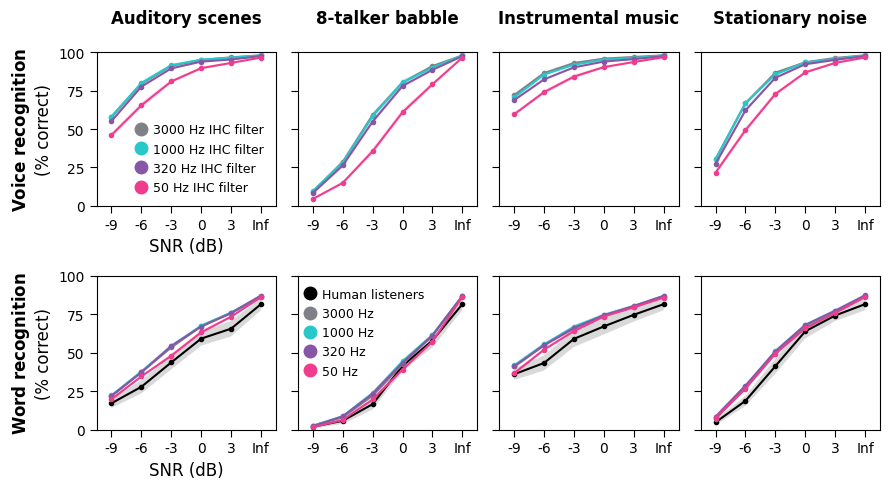

figures_poster/results_spkr_word_kell_like.pdf


In [7]:
importlib.reload(util_spkr_word_psychophysics_figures)

poster = True

# tag_expt = 'kell_like_inharmonic'
tag_expt = 'kell_like'

list_key_task = ['word', 'spkr']
if poster:
    list_key_task = list_key_task[::-1]

fig, ax_arr = plt.subplots(
    nrows=len(list_key_task),
    ncols=4,
    figsize=(9 if (tag_expt == 'kell_like_inharmonic') or (poster) else 10, 2.5 * len(list_key_task)),
    sharey=True)

df_results = EXPERIMENT_DATAFRAMES[tag_expt]
for r, key_task in enumerate(list_key_task):
    list_k_model = [
        'human',
        '3000',
        '1000',
        '320',
        '50',
    ]
    if (not key_task == 'word') or ('inharmonic' in tag_expt):
        list_k_model.pop(list_k_model.index('human'))
    list_condition_title = [
        (0, 'Auditory\nscenes'),
        (1, '8-talker\nbabble'),
        (2, 'Instrumental\nmusic'),
        (3, 'Stationary\nnoise'),
    ]
    
    for c, (condition, str_title) in enumerate(list_condition_title):
        ax = ax_arr[r, c]
        for k in list_k_model:
            tag_model = map_k_to_tag_model[k]
            color, label = util.get_color_and_label_from_model_tag(tag_model)
            df = df_results[df_results.tag_model == tag_model]
            kwargs_plot_update = {
                'marker': '.',
                'ms': 6,
                'mfc': color,
                'mew': 1,
                'lw': 1.5,
                'label': label,
            }
            str_ylabel = '{} recognition\n(% correct)'.format('Word' if key_task == 'word' else 'Voice')
            kwargs_format_axes_update = {
                'str_ylabel': str_ylabel if c == 0 else None,
                'str_xlabel': 'SNR (dB)' if c == 0 else None,
                'fontsize_ticks': 10,
                'xticklabels': [-9, -6, -3, 0, 3, 'Inf'],
                'str_title': str_title.replace('\n', ' ') + '\n' if r == 0 else None,
                'fontweight_title': 'bold'
            }
            kwargs_legend_update = {
                'loc': 'lower right',
                'markerscale': 3,
                'borderaxespad': 0.75,
                'fontsize': 9,
            }
            include_legend = condition == 0
            if (key_task == 'word') or ('inharmonic' in tag_expt):
                include_legend = condition == 1
                kwargs_legend_update['loc'] = 'upper left'
                kwargs_plot_update['label'] = label.replace(' IHC filter', '')

            ax = util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition(
                ax,
                df,
                key_task=key_task,
                restrict_background_condition=[condition],
                include_legend=include_legend,
                color=color,
                kwargs_plot_update=kwargs_plot_update,
                kwargs_legend_update=kwargs_legend_update,
                kwargs_format_axes_update=kwargs_format_axes_update,
            )
            # if r == 0:
            #     ax.set_title(ax.title.get_text(), pad=15, fontweight='bold')
        str_ylabel = '{}'.format('Word' if key_task == 'word' else 'Voice')
        str_ylabel = r'$\bf{' + str_ylabel + '}$' + r' $\bf{recognition}$'
        str_ylabel += '\n(% correct)'
        if (tag_expt == 'kell_like_inharmonic') or (poster):
            ax_arr[r, 0].set_ylabel(str_ylabel)
        else:
            ax_arr[r, 0].set_ylabel(str_ylabel, rotation=0, ha='center', va='center', labelpad=60)
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/results_spkr_word_{}.pdf'.format(tag_expt)
if poster:
    fn_fig = 'figures_poster/results_spkr_word_{}.pdf'.format(tag_expt)
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


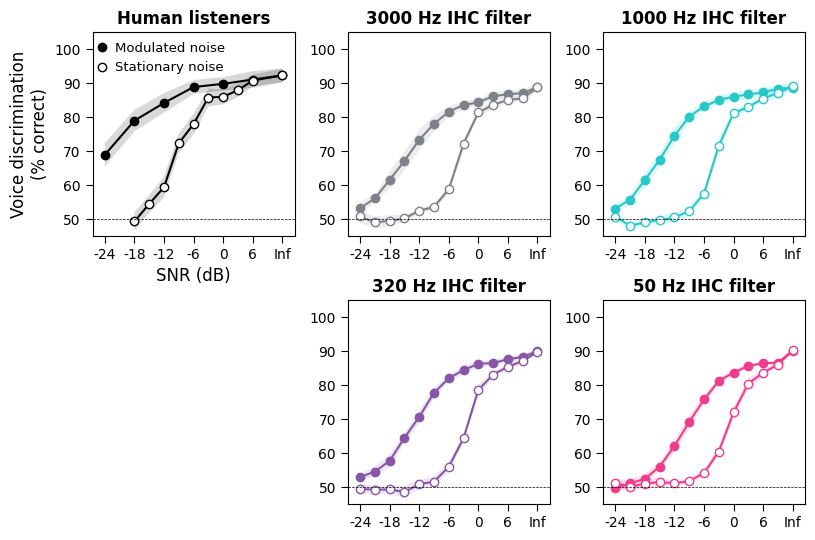

figures_src/results_spkr_discrimination_timit_ssn.pdf


In [4]:
importlib.reload(util_spkr_word_psychophysics_figures)

df_results = EXPERIMENT_DATAFRAMES['spkr_discrimination_timit_ssn']
list_k_model = [
    'human',
    '3000',
    '1000',
    '320',
    '50',
]
nrows = 1
ncols = len(list_k_model)
# fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.25 * ncols, 2.75 * nrows), sharey=True)

fig, ax_arr = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(2.75 * 3, 2.75 * 2))
ax_arr = ax_arr.reshape([-1])

for itr_ax__, k in enumerate(list_k_model):
    itr_ax = itr_ax__ if itr_ax__ < 3 else itr_ax__ + 1
    tag_model = map_k_to_tag_model[k]
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    df = df_results[df_results.tag_model == tag_model]
    ax = ax_arr[itr_ax]
    kwargs_plot_update = {
        'ms': 6,
        'mew': 1,
        'lw': 1.5,
    }
    kwargs_legend_update = {
        'loc': 'upper left',
        'markerscale': 1.,
        'borderaxespad': 0.5,
        'fontsize': 9.5,
    }
    kwargs_format_axes_update = {
        'str_title': label,
        'fontweight_title': 'bold',
        'str_ylabel': 'Voice discrimination\n(% correct)' if itr_ax == 0 else None,
        'str_xlabel': 'SNR (dB)' if itr_ax == 0 else None,
        'xticks': [-24, -18, -12, -6, 0, 6, 12],
        'xticklabels': [-24, -18, -12, -6, 0, 6, 'Inf'],
        'fontsize_ticks': 10,
    }
    ax = util_spkr_word_psychophysics_figures.make_plot_voice_discrimination(
        ax,
        df,
        color=color,
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update=kwargs_legend_update,
        kwargs_format_axes_update=kwargs_format_axes_update,
        include_legend=itr_ax == 0)
    ax.axhline(50, lw=0.5, color='k', ls='--')
ax_arr[3].axis('off')
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/results_spkr_discrimination_timit_ssn.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


In [5]:
df = df_results.loc[:, ['tag_model', 'background_condition', 'correct_list', 'snr']]
df['fn_eval'] = df['correct_list'].map(lambda _: list(np.arange(0, len(_))))
df = df.explode(['correct_list', 'fn_eval']).rename(columns={'correct_list': 'correct'})
df = df.groupby(['tag_model', 'background_condition', 'fn_eval']).agg({'snr': list, 'correct': list}).reset_index()
df = df.groupby(['tag_model', 'background_condition']).agg({'snr': 'first', 'correct': list, 'fn_eval': list}).reset_index()

def bootstrap_threshold(dfi, threshold_value=0.707, repeats=10000):
    np.random.seed(0)
    x = np.array(dfi.snr)
    list_y = np.array(dfi.correct)
    list_y = list_y[:, ~np.isinf(x)]
    x = x[~np.isinf(x)]
    list_threshold = []
    for _ in range(repeats):
        IDX = np.random.choice(
            np.arange(0, list_y.shape[0]),
            size=[list_y.shape[0]],
            replace=True)
        y = list_y[IDX].mean(axis=0)
        list_threshold.append(np.interp(threshold_value, y, x))
    return list_threshold

df['threshold_list'] = df.progress_apply(lambda _: bootstrap_threshold(_, threshold_value=0.707), axis=1)

# fig, ax = plt.subplots()
# for tag_model in ['3000_simple', '1000_simple', '320_simple', '50_simple']:
#     for background_condition in [3, 4]:
#         color, label = util.get_color_and_label_from_model_tag(map_k_to_tag_model[tag_model])
#         dfi = df[np.logical_and.reduce([
#             df.tag_model == map_k_to_tag_model[tag_model],
#             df.background_condition == background_condition,
#         ])].iloc[0]
#         x = np.array(list(dfi.snr))
#         y = np.array(list(dfi.correct))
#         y_threshold = 0.707
#         for itr in range(y.shape[0]):
#             threshold = np.interp(y_threshold, y.mean(axis=0), x)
#             ax.plot(threshold, y_threshold, color=color, marker='o', ms='3')
#         ax.plot(x, y.T, color=color, lw=0.5)
# ax.set_xlim([-17, 6])
# plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.94it/s]


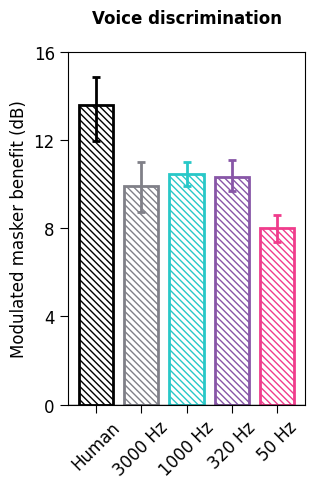

figures_src/results_spkr_discrimination_timit_ssn_benefit.pdf


In [6]:
fig, ax = plt.subplots(figsize=(3.25, 5))
ax.axhline(0, color='k', lw=1)
xticks = []
xticklabels = []
for x, k_model in enumerate(list_k_model):
    tag_model = map_k_to_tag_model[k_model]
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    dfi = df[df.tag_model == tag_model]
    y_list = np.array(list(dfi.threshold_list.values))
    y_list = y_list[0] - y_list[1]
    y = np.mean(y_list)
    yerr = np.abs(np.percentile(y_list, [2.5, 97.5]).reshape([2, 1]) - y)
    ax.errorbar(x, y, yerr, elinewidth=2, capthick=2, capsize=3, color=color)
    kwargs = {
        'color': 'w',
        'edgecolor': color,
        'lw': 2,
        'width': 0.75,
        'hatch': '\\\\\\\\\\',
    }
    ax.bar(x, y, **kwargs)
    xticks.append(x)
    xticklabels.append(label.replace(" IHC filter", "").replace(" listeners", ""))
ax = util_figures.format_axes(
    ax,
    ylimits=[0, 16],
    xticks=xticks,
    xticklabels=xticklabels,
    yticks=[0, 4, 8, 12, 16],
    str_ylabel='Modulated masker benefit (dB)',
    str_title='Voice discrimination\n',
    fontweight_title='bold',
)
ax.set_xticklabels(xticklabels, rotation=45)
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/results_spkr_discrimination_timit_ssn_benefit.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


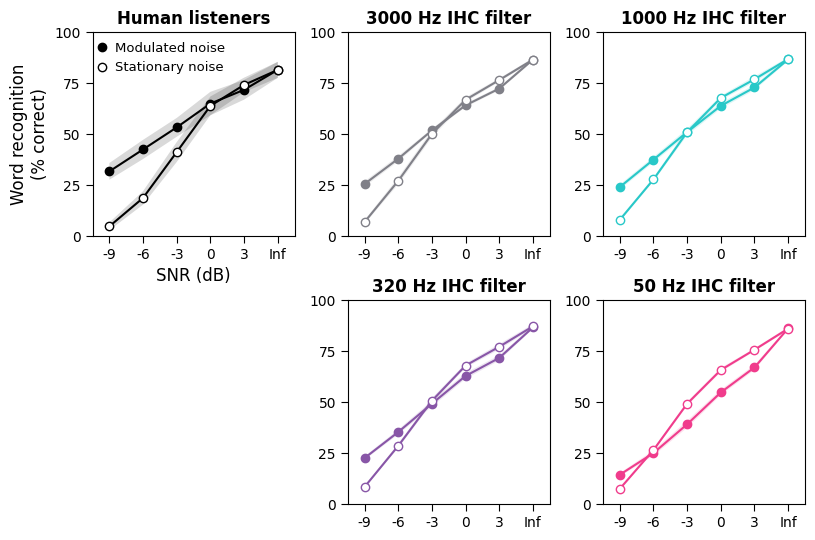

figures_src/results_word_kell_like_dip_listening.pdf


In [10]:
importlib.reload(util_spkr_word_psychophysics_figures)

df_results = EXPERIMENT_DATAFRAMES['kell_like']
key_task = 'word'
list_k_model = [
    'human',
    '3000',
    '1000',
    '320',
    '50',
]
# nrows = 1
# ncols = len(list_k_model)
# fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.25 * ncols, 2.5 * nrows), sharey=True)
fig, ax_arr = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(2.75 * 3, 2.75 * 2))
ax_arr = ax_arr.reshape([-1])
for itr_ax__, k in enumerate(list_k_model):
    itr_ax = itr_ax__ if itr_ax__ < 3 else itr_ax__ + 1
    ax = ax_arr[itr_ax]
    tag_model = map_k_to_tag_model[k]
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    df = df_results[df_results.tag_model == tag_model]
    kwargs_plot_update = {
        'marker': 'o',
        'ms': 6,
#         'mfc': color,
        'mew': 1,
        'lw': 1.5,
#         'label': label,
    }
    str_ylabel = '{} recognition\n(% correct)'.format('Word' if key_task == 'word' else 'Voice')
    kwargs_format_axes_update = {
        'str_ylabel': str_ylabel if itr_ax == 0 else None,
        'str_xlabel': 'SNR (dB)' if itr_ax == 0 else None,
        'fontsize_ticks': 10,
        'xticklabels': [-9, -6, -3, 0, 3, 'Inf'],
        'str_title': label,
        'fontweight_title': 'bold'
    }
    kwargs_legend_update = {
        'loc': 'upper left',
        'markerscale': 1.,
        'borderaxespad': 0.5,
        'fontsize': 9.5,
    }
    ax = util_spkr_word_psychophysics_figures.make_plot_kell_like_recognition(
        ax,
        df,
        key_task=key_task,
        restrict_background_condition=[4, 3],
        include_legend=itr_ax == 0,
        color=color,
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update=kwargs_legend_update,
        kwargs_format_axes_update=kwargs_format_axes_update,
    )
ax_arr[3].axis('off')
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/results_{}_kell_like_dip_listening.pdf'.format(key_task)
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


In [11]:
df = df_results[df_results.background_condition.isin([4, 3])]
df = df.loc[:, ['tag_model', 'background_condition', 'correct_word_list', 'snr']]
df['fn_eval'] = df['correct_word_list'].map(lambda _: list(np.arange(0, len(_))))
df = df.explode(['correct_word_list', 'fn_eval']).rename(columns={'correct_word_list': 'correct'})

df = df.groupby(['tag_model', 'background_condition', 'fn_eval']).agg({'snr': list, 'correct': list}).reset_index()
df = df.groupby(['tag_model', 'background_condition']).agg({'snr': 'first', 'correct': list, 'fn_eval': list}).reset_index()

df['threshold_list'] = df.progress_apply(lambda _: bootstrap_threshold(_, threshold_value=0.25), axis=1)
df


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.93it/s]


,tag_model,background_condition,snr,correct,fn_eval,threshold_list
0,human,3.0,"[-9.0, -6.0, -3.0, 0.0, 3.0, inf]","[[0.0, 0.2727272727272727, 0.4666666666666667,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-5.079317090521073, -5.481347182103128, -5.31..."
1,human,4.0,"[-9.0, -6.0, -3.0, 0.0, 3.0, inf]","[[0.5, 0.25, 0.5714285714285714, 0.75, 0.33333...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-9.0, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0, -9...."
2,saved_models/augmented_2022JAN/taskSW/IHC0050H...,3.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.0, 0.0, 0.0, 0.0026595744680851063, 0.0877...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-6.2478991596638656, -6.252808988764045, -6.1..."
3,saved_models/augmented_2022JAN/taskSW/IHC0050H...,4.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.013297872340425532, 0.023936170212765957, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-6.0604534005037785, -5.847272727272728, -6.0..."
4,saved_models/augmented_2022JAN/taskSW/IHC0320H...,3.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.0, 0.0, 0.0, 0.0, 0.07446808510638298, 0.2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-6.6356589147286815, -6.3285917496443815, -6...."
5,saved_models/augmented_2022JAN/taskSW/IHC0320H...,4.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.026595744680851064, 0.034574468085106384, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-8.514893617021276, -8.294117647058824, -8.50..."
6,saved_models/augmented_2022JAN/taskSW/IHC1000H...,3.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.0, 0.0, 0.0, 0.0026595744680851063, 0.0957...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-6.5086782376502, -6.2797297297297305, -6.532..."
7,saved_models/augmented_2022JAN/taskSW/IHC1000H...,4.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.031914893617021274, 0.05053191489361702, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-8.754752851711027, -8.807780320366131, -8.88..."
8,saved_models/augmented_2022JAN/taskSW/IHC3000H...,3.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.0, 0.0, 0.0, 0.005319148936170213, 0.05585...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-6.524528301886793, -6.154166666666667, -6.40..."
9,saved_models/augmented_2022JAN/taskSW/IHC3000H...,4.0,"[-21.0, -18.0, -15.0, -12.0, -9.0, -6.0, -3.0,...","[[0.02925531914893617, 0.0425531914893617, 0.0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[-9.352941176470587, -8.943514644351465, -9.16..."


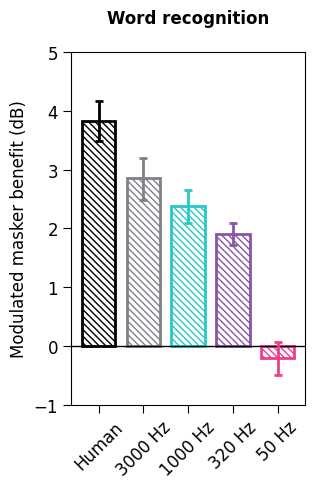

figures_src/results_word_kell_like_dip_listening_benefit.pdf


In [12]:
fig, ax = plt.subplots(figsize=(3.25, 5))
ax.axhline(0, color='k', lw=1)
xticks = []
xticklabels = []
for x, k_model in enumerate(list_k_model):
    tag_model = map_k_to_tag_model[k_model]
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    dfi = df[df.tag_model == tag_model]
    y_list = np.array(list(dfi.threshold_list.values))
    y_list = y_list[0] - y_list[1]
    y = np.mean(y_list)
    yerr = np.abs(np.percentile(y_list, [2.5, 97.5]).reshape([2, 1]) - y)
    # yerr = 2 * np.std(y_list)
    ax.errorbar(x, y, yerr, elinewidth=2, capthick=2, capsize=3, color=color)
    kwargs = {
        'color': 'w',
        'edgecolor': color,
        'lw': 2,
        'width': 0.75,
        'hatch': '\\\\\\\\\\',
    }
    ax.bar(x, y, **kwargs)
    xticks.append(x)
    xticklabels.append(label.replace(" IHC filter", "").replace(" listeners", ""))
ax = util_figures.format_axes(
    ax,
    ylimits=[-1, 5],
    xticks=xticks,
    xticklabels=xticklabels,
    str_ylabel='Modulated masker benefit (dB)',
    str_title='Word recognition\n',
    fontweight_title='bold',
)
ax.set_xticklabels(xticklabels, rotation=45)
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/results_{}_kell_like_dip_listening_benefit.pdf'.format(key_task)
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


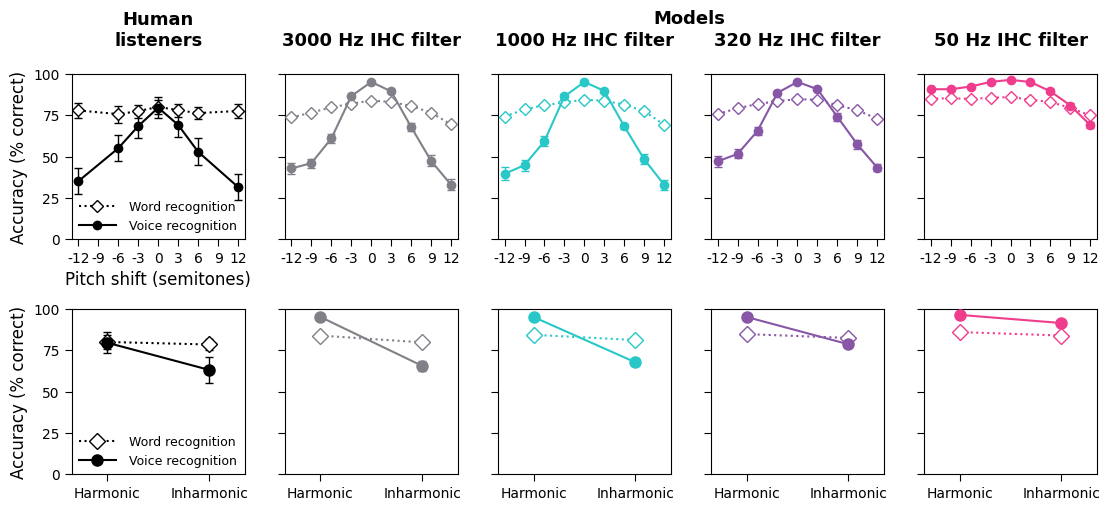

figures_src/results_spkr_word_pitch_altered.pdf


In [7]:
importlib.reload(util_spkr_word_psychophysics_figures)

df_results = EXPERIMENT_DATAFRAMES['pitch_altered']
list_k_model = [
    'human',
    '3000',
    '1000',
    '320',
    '50',
]

nrows = 2
ncols = len(list_k_model)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.25 * ncols, 2.6 * nrows), sharey=True)

for c, k in enumerate(list_k_model):
    tag_model = map_k_to_tag_model[k]
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    df = df_results[df_results.tag_model == tag_model]
    kwargs_plot_update = {
        'ms': 6,
        'mew': 1,
        'lw': 1.5,
    }
    kwargs_legend_update = {
        'fontsize': 9,
        'markerscale': 1.0,
        'borderaxespad': 0.25,
        'handlelength': 3,
    }
    if 'human' in tag_model:
        label = 'Human\nlisteners'
    else:
        label = '\n' + label
    kwargs_format_axes_update = {
        'str_title': label + '\n',
        'fontweight_title': 'bold',
        'fontsize_title': 13,
        'fontsize_ticks': 10,
        'str_ylabel': 'Accuracy (% correct)' if c == 0 else None,
        'str_xlabel': 'Pitch shift (semitones)' if c == 0 else None,
    }
    ax = ax_arr[0, c]
    util_spkr_word_psychophysics_figures.make_plot_pitch_shifted_recognition(
        ax,
        df,
        color=color,
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update=kwargs_legend_update,
        kwargs_format_axes_update=kwargs_format_axes_update,
        include_legend=c == 0)
    kwargs_format_axes_update = {
        'fontsize_ticks': 10,
        'str_ylabel': 'Accuracy (% correct)' if c == 0 else None,
        'str_xlabel': None,
    }
    ax = ax_arr[1, c]
    util_spkr_word_psychophysics_figures.make_plot_pitch_condition_recognition(
        ax,
        df,
        color=color,
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update=kwargs_legend_update,
        kwargs_format_axes_update=kwargs_format_axes_update,
        include_legend=c == 0)
plt.tight_layout()
fig.suptitle('Models', fontsize=13, fontweight='bold', x=0.6175, y=0.9725, ha='center', va='top')
plt.show()

fn_fig = 'figures_src/results_spkr_word_pitch_altered.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


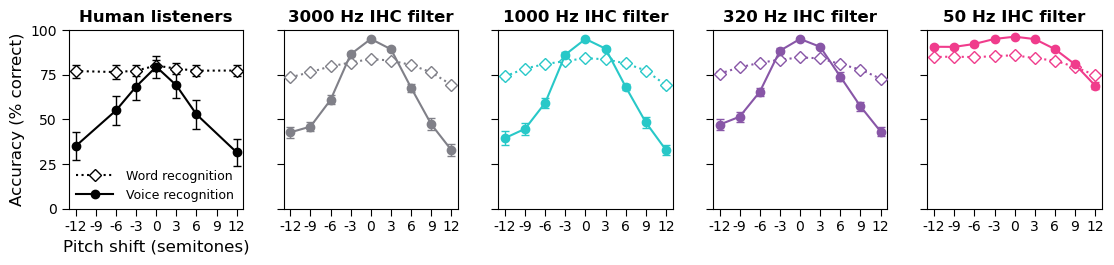

figures_poster/results_spkr_word_pitch_shift.pdf


In [24]:
importlib.reload(util_spkr_word_psychophysics_figures)

df_results = EXPERIMENT_DATAFRAMES['pitch_altered']
list_k_model = [
    'human',
    '3000',
    '1000',
    '320',
    '50',
]

nrows = 1
ncols = len(list_k_model)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.25 * ncols, 2.75 * nrows), sharey=True)
ax_arr = ax_arr.reshape([nrows, ncols])

for c, k in enumerate(list_k_model):
    tag_model = map_k_to_tag_model[k]
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    df = df_results[df_results.tag_model == tag_model]
    kwargs_plot_update = {
        'ms': 6,
        'mew': 1,
        'lw': 1.5,
    }
    kwargs_legend_update = {
        'fontsize': 9,
        'markerscale': 1.0,
        'borderaxespad': 0.25,
        'handlelength': 3,
    }
    kwargs_format_axes_update = {
        'str_title': label,
        'fontweight_title': 'bold',
        'fontsize_ticks': 10,
        'str_ylabel': 'Accuracy (% correct)' if c == 0 else None,
        'str_xlabel': 'Pitch shift (semitones)' if c == 0 else None,
    }
    ax = ax_arr[0, c]
    util_spkr_word_psychophysics_figures.make_plot_pitch_shifted_recognition(
        ax,
        df,
        color=color,
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update=kwargs_legend_update,
        kwargs_format_axes_update=kwargs_format_axes_update,
        include_legend=c == 0)
    kwargs_format_axes_update = {
        'fontsize_ticks': 10,
        'str_ylabel': 'Accuracy (% correct)' if c == 0 else None,
        'str_xlabel': None,
    }
plt.tight_layout()
plt.show()

fn_fig = 'figures_poster/results_spkr_word_pitch_shift.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


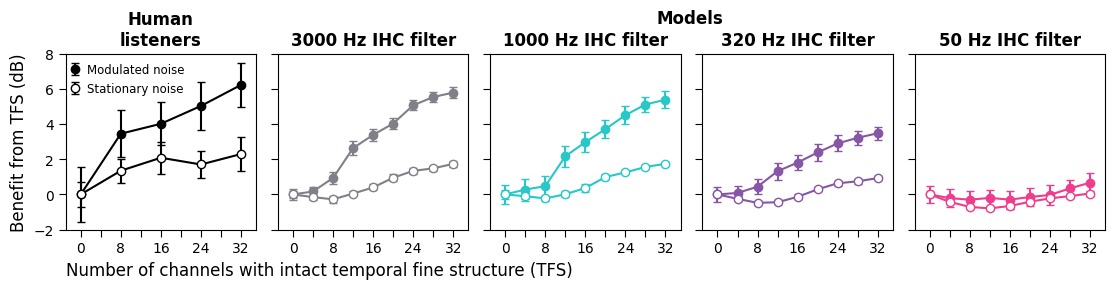

figures_src/results_word_tfs_manipulation_benefit.pdf


In [45]:
importlib.reload(util_spkr_word_psychophysics_figures)

df_results = EXPERIMENT_DATAFRAMES['hopkins_moore_2009']
list_k_model = [
    'human',
    '3000',
    '1000',
    '320',
    '50',
]

nrows = 1
ncols = len(list_k_model)
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.25 * ncols, 2.75 * nrows), sharey=True)

for itr_ax, k in enumerate(list_k_model):
    tag_model = map_k_to_tag_model[k]
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    df = df_results[df_results.tag_model == tag_model]
    kwargs_plot_update = {
        'ms': 6,
        'mew': 1,
        'lw': 1.5,
    }
    kwargs_legend_update = {
        'fontsize': 8.5,
        'markerscale': 1.0,
        'borderaxespad': 0.5,
        'handlelength': 0,
    }
    if  'human' in tag_model:
        label = 'Human\nlisteners'
    else:
        label = '\n' + label
    kwargs_format_axes_update = {
        'str_title': label,
        'fontweight_title': 'bold',
        'fontsize_ticks': 10,
        'str_ylabel': 'Benefit from TFS (dB)' if itr_ax == 0 else None,
        'str_xlabel': None,
    }
    ax = ax_arr[itr_ax]
    util_spkr_word_psychophysics_figures.make_plot_hopkins_moore_2009_tfs_benefit(
        ax,
        df,
        color=color,
        kwargs_plot_update=kwargs_plot_update,
        kwargs_legend_update=kwargs_legend_update,
        kwargs_format_axes_update=kwargs_format_axes_update,
        include_legend=itr_ax == 0,
    )
plt.tight_layout()
ax_arr[0].set_xlabel('Number of channels with intact temporal fine structure (TFS)', ha='left', x=0)
fig.suptitle('Models', fontsize=12, fontweight='bold', x=0.6175, y=0.95, ha='center', va='top')
plt.show()

fn_fig = 'figures_src/results_word_tfs_manipulation_benefit.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


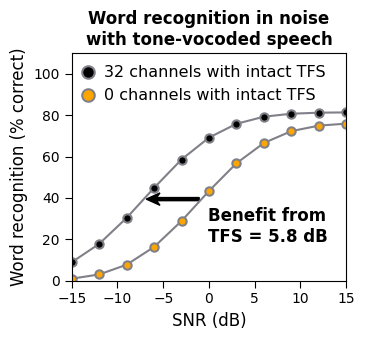

figures_src/schematic_tfs_manipulation_benefit.pdf


In [33]:
df_results = EXPERIMENT_DATAFRAMES['hopkins_moore_2009_raw']
tag_model = map_k_to_tag_model['3000']
color, label = util.get_color_and_label_from_model_tag(tag_model)
df = df_results[np.logical_and.reduce([
    df_results.tag_model == tag_model,
    df_results.background_condition == 4.0,
    df_results.cutoff_channel.isin([32.0, 0.0]),
])]

fig, ax = plt.subplots(figsize=(3.75, 3.5))
list_x = []
list_y = []
for cutoff_channel in [32, 0]:
    dfi = df[df.cutoff_channel == cutoff_channel]
    popt = np.stack(dfi.popt.values).mean(axis=0)
    fcn_to_fit = lambda x, p0, p1, p2: p0 * scipy.stats.norm(p1, p2).cdf(x)
    fit_fcn = lambda x: fcn_to_fit(x, *popt)
    x = np.stack(dfi.snr.values).reshape([-1])
    y = np.stack(dfi.correct_word.values).reshape([-1])
    x[np.isinf(x)] = -21
    y = y[x >= -15]
    x = x[x >= -15]
    kwargs_plot = {
        'ls': '-',
        'lw': 1.5,
        'marker': 'o',
        'ms': 6,
        'mew': 1.5,
        'color': color,
        'mfc': 'k' if cutoff_channel == 32.0 else 'orange',
        'label': '{:.0f} channels with intact TFS'.format(cutoff_channel),
    }
    ax.plot(np.unique(x), 100 * fit_fcn(np.unique(x)), **kwargs_plot)
    list_x.append(popt[1])
    list_y.append(100 * fit_fcn(popt[1]))
list_x = np.array(list_x)
list_y = np.array(list_y)
list_y[:] = list_y.mean()
kwargs_arrow = {
    'width': 1.5,
    'head_width': 6,
    'head_length': 1.5,
    'length_includes_head': True,
    'color': 'k',
    'overhang': 0.25,
}
ax.arrow(
    x=list_x[1],
    y=list_y[1],
    dx=list_x[0] - list_x[1],
    dy=list_y[0] - list_y[1],
    **kwargs_arrow)
ax.text(
    list_x[1] + 1,
    list_y[1] - 4,
    'Benefit from\nTFS = {:.1f} dB'.format(list_x[1] - list_x[0]),
    weight='bold',
    color='k',
    fontsize=12,
    verticalalignment='top')
kwargs_legend = {
    'loc': 'upper left',
    'fontsize': 11.5,
    'frameon': False,
    'handlelength': 0.5,
    'markerscale': 1.5,
    'borderaxespad': 0.75,
    'borderpad': 0,
}
ax.legend(**kwargs_legend)
ax = util_figures.format_axes(
    ax,
    xlimits=[-15, 15],
    xticks=np.arange(-15, 16, 5),
    ylimits=[0, 110],
    fontsize_ticks=10,
    str_xlabel='SNR (dB)',
    str_ylabel='Word recognition (% correct)',
    str_title='Word recognition in noise\nwith tone-vocoded speech',
    fontweight_title='bold')
plt.tight_layout()
plt.show()

fn_fig = 'figures_src/schematic_tfs_manipulation_benefit.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)


In [20]:
def filterbank_function(x, itr_channel=None):
    """
    """
    rfft_x = np.fft.rfft(x)
    if itr_channel is None:
        rfft_x = rfft_x[np.newaxis, :]
        rfft_x_subbands = rfft_x * filts
    else:
        rfft_x_subbands = rfft_x * filts[itr_channel]
    x_subbands = np.fft.irfft(rfft_x_subbands)
    return x_subbands


def vocode_above_cutoff(
        x,
        sr,
        x_subbands_hilbert=None,
        cutoff_channel=0,
        filterbank_function=None,
        filterbank_cfs=None,
        mode='tone'):
    """
    """
    if len(x.shape) == 2 and x.shape[0] == len(filterbank_cfs):
        x_subbands = x.copy()
    else:
        x_subbands = filterbank_function(x)
    if x_subbands_hilbert is None:
        x_subbands_hilbert = scipy.signal.hilbert(x_subbands, N=None, axis=-1)
    for itr_channel in range(cutoff_channel, x_subbands.shape[0]):
        cf = filterbank_cfs[itr_channel]
        t = np.arange(0, x_subbands.shape[-1]) / sr
        if mode == 'tone':
            v = np.sin(2 * np.pi * cf * t)
            v = v * np.abs(x_subbands_hilbert[itr_channel])
            v = filterbank_function(v, itr_channel=itr_channel)
        elif mode == 'noise':
            v = np.random.randn(*t.shape)
            v = v * np.abs(x_subbands_hilbert[itr_channel])
            v = filterbank_function(v, itr_channel=itr_channel)
            v = util_stimuli.set_dBSPL(v, util_stimuli.get_dBSPL(x_subbands[itr_channel]))
        else:
            raise ValueError("mode=`{}` is not recgonized".format(mode))
        x_subbands[itr_channel] = v
    x_env = np.abs(x_subbands_hilbert)
    return x_subbands, x_env


fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/foreground_swc/022_animals.wav'
y_src, sr_src = sf.read(fn)
sr = 20000
dur = 2.0
y = soxr.resample(y_src, sr_src, sr)
y = util_stimuli.set_dBSPL(util_stimuli.pad_or_trim_to_len(y, int(dur * sr)), 60.0)

cfs = util_signal.erbspace(80, 8000, 32)
QERB = cfs / (24.7 * (1 + 4.37 * (cfs / 1000)))
bws = cfs / QERB
signal_length = int(sr * dur)
filts, freqs = util_signal.make_roex_filters(
    signal_length,
    sr,
    cfs=cfs,
    bws=bws,
    dc_ramp_cutoff=30)

co = 10
subbands, envelopes  = vocode_above_cutoff(y, sr, cutoff_channel=co, filterbank_function=filterbank_function, filterbank_cfs=cfs)
subbands.shape


(32, 40000)

/tmp/ipykernel_31071/971616888.py:28: RuntimeWarning: divide by zero encountered in log10
  ax.plot(20 * np.log10(filts[fidx, :] / filts.max()), freqs, color='k', lw=1)


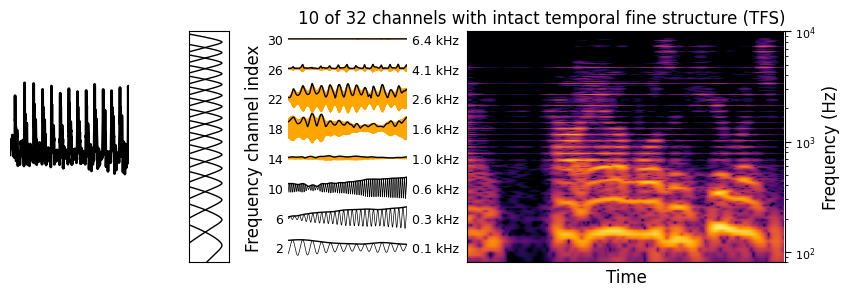

figures_src/schematic_tfs_manipulation.pdf


In [22]:
gridspec_kw = {
    'width_ratios': [3, 1, 3, 8],
    'wspace': 0.4
}
fig, ax_arr = plt.subplots(figsize=(10, 3), nrows=1, ncols=4, gridspec_kw=gridspec_kw)
xlimits = [0.8, 0.9]

ax = ax_arr[0]
t = np.arange(0, y.shape[0]) / sr
ax.plot(t, y-y.mean(), color='k', lw=2)
ax = util_figures.format_axes(
    ax,
    xlimits=xlimits,
    ylimits=[-0.2, 0.2],
    xticks=[],
    xticks_minor=[],
    xticklabels=None,
    yticks=[],
    yticks_minor=[],
    yticklabels=None,
    xscale='linear',
    yscale='linear',
    spines_to_hide=['top', 'bottom', 'left', 'right'],
)

ax = ax_arr[1]
for fidx in range(1, filts.shape[0], 2):
    ax.plot(20 * np.log10(filts[fidx, :] / filts.max()), freqs, color='k', lw=1)
ax = util_figures.format_axes(
    ax,
    ylimits=[80, 10e3],
    xlimits=[-40, 8],
    xticks=[],
    xticks_minor=[],
    xticklabels=None,
    yticks=[],
    yticks_minor=[],
    yticklabels=None,
    xscale='linear',
    yscale='log',
#     str_ylabel='Frequency channel number',
)
ax.patch.set_facecolor('w')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Frequency channel index', labelpad=12)

ax = ax_arr[2]
env = True
offset = 0.5
color = 'orange'
tfs_lw = 0.5
env_lw = 1
yticks = []
yticklabels_l = []
yticklabels_r = []
for itr0 in range(1, subbands.shape[0], 4):
# for itr0 in [0, 3, 7, 11, 15, 19, 23, 27]:
    if itr0 < co:
        ax.plot(t, subbands[itr0]/subbands[itr0].max() + offset * itr0, color='k', lw=tfs_lw)
    else:
        ax.plot(t, subbands[itr0]/subbands[itr0].max() + offset * itr0, color=color, lw=tfs_lw)
    if env:
        ax.plot(t, envelopes[itr0]/envelopes[itr0].max() + offset * itr0, color='k', lw=env_lw)
    yticks.append(offset * itr0)
    yticklabels_l.append(itr0 + 1)
    yticklabels_r.append('{:.1f} kHz'.format(np.round(cfs[itr0] / 1e3, decimals=1)))
ax = util_figures.format_axes(
    ax,
    xlimits=xlimits,
    ylimits=[-offset, offset * (itr0 + 1)],
    xticks=[],
    xticks_minor=[],
    xticklabels=None,
    yticks=yticks,
    yticks_minor=[],
    yticklabels=yticklabels_l,
#     str_ylabel='Frequency channel',
    xscale='linear',
    yscale='linear',
    fontsize_ticks=9,
    spines_to_hide=['top', 'bottom', 'left', 'right'],
    major_tick_params_kwargs_update={'length': 0})
ax.yaxis.set_ticks_position('both')
ax_r = ax.secondary_yaxis('right')
ax_r.tick_params(labelsize=9, direction='out', length=0)
ax_r.set_yticks(yticks)
ax_r.set_yticklabels(yticklabels_r)
ax_r.spines[['right']].set_visible(False)

ax = ax_arr[3]
nfft = 2 ** 11
kwargs_specgram = {
    'NFFT': nfft,
    'Fs': sr,
    'mode': 'magnitude',
    'scale': 'dB',
    'cmap': 'inferno',
    'noverlap': int(0.9 * nfft),
    'clim': [-100, -30],
}
ax.specgram(subbands.sum(axis=0), **kwargs_specgram)
ax = util_figures.format_axes(
    ax,
    xticks=[],
    xlimits=[0.25, 1.75],
    ylimits=[80, 10e3],
    yscale='log',
    fontsize_ticks=8,
    str_xlabel='Time',
    str_ylabel='Frequency (Hz)',
)
ax.set_title(f'{co} of {len(cfs)} channels with intact temporal fine structure (TFS)', ha='right', fontsize=12, x=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.show()

fn_fig = 'figures_src/schematic_tfs_manipulation.pdf'
fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=True)
print(fn_fig)
